In [53]:
from torch import nn

### Seq2Seq结构

In [2]:
class Encoder(nn.Module):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        
    def forward(self,X,*args):
        raise NotImplementedError

In [4]:
#解码器
class Decoder(nn.Module):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)

    def init_state(self,enc_outputs,*args):
        raise NotImplementedError
        
    def forward(self,X,state):
        raise NotImplementedError

In [5]:
#合并编码器和解码器
class EncoderDecoder(nn.Module):
    def __init__(self,encoder,decoder,**kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    def forward(self,enc_X,dec_X,*args):
        enc_outputs = self.encoder(enc_X,*args)
        dec_state = self.decoder.init_state(enc_outputs,*args)
        return self.decoder(dec_X,dec_state)
        

<img src="encoder和decoder_01.png" width="800" >
<img src="encoder和decoder_02.png" width="800" >

In [6]:
import collections
import math
import torch
import d2l.torch as d2l


In [18]:
#seq2seq encoder
class Seq2SeqEncoder(Encoder):
    def __init__(self,vocab_size,embed_size,num_hiddens,num_layers,dropout=0,**kwargs):
        super().__init__(**kwargs)
        #嵌入层
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.rnn = nn.GRU(embed_size,num_hiddens,num_layers,dropout=dropout)

    def forward(self,X,*args):
        #注意X的形状，在进行embedding之前，x的形状是多少？一般都是（batch_size,num_steps,vocab_size）
        #X经过embedding处理，X的形状：（batch_size,num_steps,embed_size）
        X = self.embedding(X)
        #根据文档说明，GRU默认是：（num_steps,batch_size,embed_size）所以要调换一下维度顺序
        X = X.permute(1,0,2)
        #没有手动传入state，这时，pytorch会帮我们完成隐藏状态的初始化，即0
        output,state = self.rnn(X)
        #output的形状：（num_steps,batch_size,num_hiddens）
        #state的形状：（num_layers,batch_size,num_hiddens）
        return output,state

In [15]:
encoder = Seq2SeqEncoder(vocab_size=10,embed_size=8,num_hiddens=16,num_layers=2)
encoder.eval()
#batch_size=4,num_steps=7
X = torch.zeros((4,7),dtype=torch.long)
output,state = encoder(X)

In [23]:
output.shape,state.shape

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

In [118]:
#seq2seq decoder
class Seq2SeqDecoder(Encoder):
    def __init__(self,vocab_size,embed_size,num_hiddens,num_layers,dropout=0,**kwargs):
        super().__init__(**kwargs)
        #嵌入层
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens,num_hiddens,num_layers,dropout=dropout)
        #输出层
        self.dense = nn.Linear(num_hiddens,vocab_size)

    def init_state(self,enc_outputs,*args):
        return enc_outputs[1]
        
    def forward(self,X,state):
        #X经过embedding处理，X的形状（batch_size,num_steps,embed_size）
        X = self.embedding(X)
        #根据文档说明，GRU默认是：（num_steps,batch_size,embed_size）所以要调换一下维度顺序
        X = X.permute(1,0,2)
        #把X和state拼接到一起，方便计算
        #print('X现在的形状（num_steps,batch_size,embed_size）:',X.shape)
        #print('最后一层state的形状（batch_size,num_hiddens）:',state[-1].shape)
        #X现在的形状（num_steps,batch_size,embed_size）最后一层state的形状（batch_size,num_hiddens）
        #要把state的形状扩充成三维，变成（numn_steps,batch_size,embed_size）
        context = state[-1].repeat(X.shape[0],1,1)
        #print('要把state的形状扩充成三维，变成（numn_steps,batch_size,num_hiddens）:',context.shape)
        X_and_context = torch.cat((X,context),2)
        #print('X_and_context:',X_and_context.shape)
        output,state = self.rnn(X_and_context,state)
        output = self.dense(output).permute(1,0,2)
        #output的形状：（batch_size,num_steps,vocab_size）
        #state的形状：（num_layers,batch_size,num_hiddens）
        return output,state

In [51]:
decoder = Seq2SeqDecoder(vocab_size=10,embed_size=8,num_hiddens=16,num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output,state = decoder(X,state)


X现在的形状（num_steps,batch_size,embed_size）: torch.Size([7, 4, 8])
最后一层state的形状（batch_size,num_hiddens）: torch.Size([4, 16])
要把state的形状扩充成三维，变成（numn_steps,batch_size,num_hiddens）: torch.Size([7, 4, 16])
X_and_context: torch.Size([7, 4, 24])


In [41]:
output.shape,state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [34]:
randint_tensor = torch.randint(0, 10, (4, 16))  # [0, 10)的随机整数ones_tensor
randint_tensor.shape

torch.Size([4, 16])

In [33]:
randint_tensor.repeat(7,1,1).shape

torch.Size([7, 4, 16])

### Seq2Seq训练

In [56]:
torch.arange((3))[None,:]

tensor([[0, 1, 2]])

In [58]:
torch.tensor([1,1])[:,None]

tensor([[1],
        [1]])

In [59]:
torch.arange((3))[None,:] < torch.tensor([1,1])[:,None]

tensor([[ True, False, False],
        [ True, False, False]])

In [60]:
torch.tensor([1,1]).reshape(2,1)

tensor([[1],
        [1]])

#### 重写交叉熵损失，添加屏蔽无效内容的部分

In [107]:
#seq2seq的训练，pytorch中训练代码，都是一个套路
def sequence_mask(X,valid_len,value=0):
    #找到最大序列长度
    maxlen = X.size(1)
    mask = torch.arange((maxlen),dtype=torch.float32,device=X.device)[None] < valid_len[:,None]
    #print(mask)
    X[~mask] = value
    return X

In [66]:
x2 = torch.ones(2,3,4)
x2

tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])

In [67]:
sequence_mask(x2,torch.tensor([1,1]))

tensor([[ True, False, False],
        [ True, False, False]])


tensor([[[1., 1., 1., 1.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[1., 1., 1., 1.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])

In [108]:
#重写交叉熵损失，添加屏蔽无效内容的部分
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    #重写forward
    #pred的形状（batchsize,num_steps,vocab_size）
    #label的形状（batchsize,num_steps）
    #valid_len的形状（batchsize,）
    def forward(self,pred,label,valid_len):
        weights = torch.ones_like(label)     
        weights = sequence_mask(weights,valid_len)
        #先调用原始的交叉熵损失，就可以计算没有被mask的损失
        self.reduction = 'none'
        unweighted_loss = super().forward(pred.permute(0,2,1),label)
        #print(unweighted_loss)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss


In [109]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3,4,10),torch.ones((3,4),dtype=torch.long),torch.tensor([4,2,0]))

tensor([2.3026, 1.1513, 0.0000])

In [88]:
uniform_tensor = torch.rand(2, 2) 
uniform_tensor

tensor([[0.0536, 0.0343],
        [0.6146, 0.8206]])

In [90]:
uniform_tensor.mean(dim=1)

tensor([0.0440, 0.7176])

#### 训练代码

In [115]:
#训练方法
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    #初始化  RNN网络的xavier初始化的代码都一样
    def xavier_init_weights(m):
        #判断模型是线性模型时
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        #若模型为GRU（2层循环层）模型时
        if type(m) == nn.GRU:
            #遍历每一层的权重参数名称
            for param in m._flat_weights_names:
                #若权重在参数中
                if 'weight' in param:
                    nn.init.xavier_uniform_(m._parameters[param])
                    
    #网络应用xavier初始化的权重
    net.apply(xavier_init_weights)
    
    #网络转移到device上
    net.to(device)
    
    #用网络初始化的参数与学习率设置优化器
    optimizer = torch.optim.Adam(net.parameters(),lr=lr)
    
    #创建损失函数的实例对象
    loss = MaskedSoftmaxCELoss()
    
    #设置实时更新的画图可视化dltools.Animator()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs])

    for epoch in range(num_epochs):
        
        timer = d2l.Timer()   #训练数据的计时
        metric = d2l.Accumulator(2) #累加统计两种数值：训练的总损失， 词元数量

        for batch in data_iter:#遍历数据迭代器的批次
            #梯度清零
            optimizer.zero_grad()
            
            #取数据
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1,1)
            # 开头加上了bos, 那么Y就要去掉最后一列, 保证序列的长度不变. 
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  #给每一行都加上bos
            
            #获取预测值，state不接收
            Y_pred, _ = net(X, dec_input, X_valid_len)
            
            #计算损失
            l = loss(Y_pred, Y, Y_valid_len)  #Y_valid_len属于*args其他位置参数传入的
            
            #反向传播
            l.sum().backward()
            
            #梯度裁剪
            d2l.grad_clipping(net,theta=1)
            
            #更新梯度
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad(): #不求导
                metric.add(l.sum(),num_tokens)
            
        if (epoch+1) % 10 ==0:  #若每训练循环10次
            animator.add(epoch+1, (metric[0]/ metric[1]))
            print(f'loss {metric[0]/ metric[1]:.3f}, {metric[1] / timer.stop():.1f}', f'tokens/sec on {str(device)}')

loss 0.032, 11184.9 tokens/sec on cuda:0


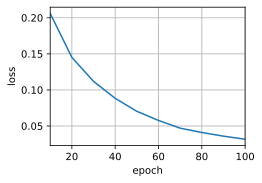

In [119]:
#验证封装的训练代码
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10

lr, num_epochs, device = 0.005, 100, d2l.try_gpu()
 
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size=batch_size,num_steps=num_steps)
 
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
 
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
 
net = EncoderDecoder(encoder, decoder)
 
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [123]:
#预测代码 
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps, device):
    """
    src_sentence：传入的需要翻译的句子
    src_vocab：需要翻译的词汇表
    tgt_vocab：目标真实值词汇表
    num_steps：子序列长度
    device：GPU或CPU设备
    """
    #预测的时候需要把net设置为评估模式
    net.eval()
    #获取处理后的文本词元索引（输出是一个索引列表），在文本的结尾加上'<eos>'
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    #获取编码器输入内容src_tokens的有效长度，转化为tensor(用列表创建tensor)
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    #处理src_tokens太长/太短的问题：截断或者补充pad ,  num_steps表示隔多长截断一次, 覆盖赋值
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    
    #给src_tokens增加一个维度来表示批次,  获取enc_X 编码器的输入数据
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    #向网络的编码器中传入enc_X, enc_valid_len，获取编码器的输出结果
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    #将编码器的输出结果enc_output和有效长度enc_valid_len传入解码器中，获取解码器的输出结果初始化状态dec_state
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    
    #给预测结果也提前添加一个维度,   tgt_vocab预测词汇表的第一个词应该是文本开头的bos
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    
    output_seq = []
    for _ in range(num_steps):  #循环子序列长度次数
        #将dec_state, dec_X输入网络的解码器中
        Y, dec_state = net.decoder(dec_X, dec_state)
        #将Y重新赋值给dec_X，实现循环输入
        dec_X = Y.argmax(dim=2)  #将Y的vocab_size对应的索引2维度聚合找最大值（预测的值）
        
        #获取预测值：将dec_X去掉一个batc_size维度（此时batc_size=1，就一批数据，可以不要这个维度）
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        #判断结束的条件
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    #返回值：按照索引返回对应词表中的词
    return ' '.join(tgt_vocab.to_tokens(output_seq))

In [120]:
#评估代码
def bleu(pred_seq, label_seq, k):
    """
    pred_seq:预测序列
    label_seq：真实序列
    k： 设定几元连续
    """
    #pred_seq, label_seq预测与目标序列的空格分隔处理(分词)
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    #获取预测词与目标词的长度
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    #计算bleu的左边部分_比较最小值
    score = math.exp(min(0, 1 - (len_label / len_pred)))
    for n in range(1, k + 1):  #range左闭右开   #分几元连续的情况
        #赋值 ,  #num_matches:预测值与目标值匹配的数量， 
        #collections.defaultdict(int)创建了一个默认值为int的字典  label_subs
        num_matches, label_subs = 0, collections.defaultdict(int)
        #循环连续词元的数量
        for i in range(len_label - n + 1):
            #若预测的词能与目标值匹配上
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        
        for i in range(len_pred - n + 1):
            #若能匹配上
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1  #匹配数+1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *=  math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n)) 
    return score


In [124]:
# 开始预测
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation = predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => je sais <unk> !, bleu 0.000
i'm home . => je suis ici ., bleu 0.512


In [125]:
d2l.load_data_nmt??

Signature: d2l.load_data_nmt(batch_size, num_steps, num_examples=600)
Source:   
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset.

    Defined in :numref:`sec_utils`"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab
File:      d:\ai\pytroch_learning\lib\site-packages\d2l\torch.py
Type:      function

In [126]:
d2l.read_data_nmt??

Signature: d2l.read_data_nmt()
Source:   
def read_data_nmt():
    """Load the English-French dataset.

    Defined in :numref:`sec_utils`"""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding='utf-8') as f:
        return f.read()
File:      d:\ai\pytroch_learning\lib\site-packages\d2l\torch.py
Type:      function

In [127]:
d2l.download_extract('fra-eng')

'../data\\fra-eng'